# PHASE 4 FINAL PROJECT

## 1. BUSINESS UNDERSTANDING

### 1.1 INTRODUCTION

Creating recommendation systems is a famous problem in our society, such is the importance of such a problem that Netflix, a streaming service, once offered $1 Million as a prize to anyone who could beat their own recommendation systems by 10%. This prize was won in 2009 by a team of researchers called `Belker's Pragmatic Chaos` in 2009 after 3 years of competition. Netflix has also said that they would lose over a billion dollars each year in revenue if it wasn't for their recommendation system.

Knowing this, a startup company in Kenya called Phoenix Incorporated has decided to start its own streaming service to compete with the likes of Showmax, Netflix and Prime Video which are all available in Kenya. The idea of Phoenix as a startup company is to offer the same variety as a company like Netflix but at a lower price so as to accessible by the average Kenyan in this economy. Phoenix Incorporated understands that in order for a streaming service to be successful it has to have a good recommendation system so as to keep its clients happy and to attract new clients hence more revenue. In order to this, they have decided to hire a famous Data science firm called Regex Analytics to assist them in this task.

After meeting with one of the representatives from Phoenix Incorporated the CEO of Regex Analytics has decided to give this task to the head Data Scientist in the firm. The head has then decided to delegate this task to one of the experienced data scientists in his team. This experienced data scientist is to build a recommendation system that recommends 5 movies that users may like based on previous choices and what others liked from the streaming platform so as to address the cold start problem. The experienced data scientist is then supposed to present this model to the head data scientist who will then show it to the CEO. He is also to create a presentation on the project mentioned above as a summary of his findings to a non-technical audience which will also include some members from Phoenix Incorporated.

### 1.2 OBJECTIVES

- To build a recommendation system capable of suggesting 5 movies to users based on their past choices and popular content in the streaming service currently.

- To address the `cold start problem` to provide valuable recommendations to new users with limited interaction history.

- To optimise recommendation algorithms to maximise user satisfaction and platform revenue.

- To implement recommendation system to enhance user engagement and retention.

### 1.3 PROBLEM STATEMENT

To build a recommendation system that offers 5 recommendations to a user based on previous content and also what other users with similar interests have watched.

### 1.4 MEASURE OF SUCCESS

The goal is to build a recommendation system that recommends 5 movies to a user based on previous things watched and what other users with similar interests have watched. The measure of success will therefore be a working recommendation system that is able to offer recommendations to new and old users with at least 70% accuracy. This is lower than major platforms like Netflix's accuracy of 80% but is still a good starting point. The model can them be improved later based on suggestion from users as Netflix even as a company has been around for more than 10 years, hence it has had time to improve its recommendation systems to almost perfect.

## 2. DATA UNDERSTANDING

### 2.0 General Statement

In order to build a recommendation system the data sourced was from the `MovieLens` dataset. This is a common dataset used in making recommendation systems. This dataset consists of various csv files which each shall be explained below.

First loading libraries to see the columns for each csv file in form of a dataframe and also the libraries we might use later on.

In [109]:
# For analysis and data manipulation
import pandas as pd
import numpy as np

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Spectral")  # Setting style for plots
sns.set_style("darkgrid")
%matplotlib inline


### 2.1 Ratings

These are the ratings given to various movies and the data contained can be seen below.

In [18]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**As can be seen above the columns for ratings are `userId`, `movieId`, `rating` and `timestamp`.**

 These are defined as follows:
 - **UserId** : The unique identification of the user who gave the rating for a specific movie to help know ratings given by a user or other users.
 
 - **movieId** : The unique identification of the movie of which the user gave a rating to help know the ratings given to movies to be able to recommend correctly if a user is new to the system based on ratings of users with similar interests.

 - **rating** : The rating given by a user to a specific movie starting from 0 to 5 which is the highest score. This is to help in content and collaborative filtering.

 - **timestamp** :  This represents the date and time the user rated a movie in terms of seconds.


### 2.2 Movies

These are the IDs of the movies to be rated, the titles of the movies in question and the category in which each film belongs.

In [19]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**The columns of the movie dataframe are `movieId`, `title` and `genres`.**

These are defined as follows:
- **movieId** : Same as above unique identification of movie to be rated.

- **title** : Title of the movie to be rated used to tie the movieId to a string so that the system can know the name of a specific movieId

- **genres** : The category or the type of the film rated.

### 2.3 Links

This table contains ID data for various databases and also for the MovieLens site. This is most likely a junction table used to connect various dataframes through common columns.

In [20]:
links = pd.read_csv('links.csv')
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


**The columns are `movieId`, `imdbId` and `tmdbId`.**

They are defined as follows:

- **movieId** : Unique identifier for every movie according to the MovieLens site.

- **imdbId** : Unique identifier for every movie according to the International movie database(IMDb)

- **tmdbId** : Unique identifier for every movie according to The Movie DataBase(TMDb)

### 2.4 Tags

Contains the IDs of the movie and the users. It also contains the tags given by the user and the timestamp the user gave that tag.

In [21]:
tags = pd.read_csv('tags.csv')
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


**These are the columns present `userId`, `movieId`, `tag` and `timestamp`.**

They are defined as follows:

- **userId** : Unique identifier of user who gave a tag of a movie.

- **movieId** : Unique identifier of movie given a tag.

- **tag** : Short description of a movie given by a user to express opinions. They are used by recommendation systems to understand user preferences and make movie recommendations based on the tags assigned by users. It will therefore be useful in building a recommendation system.

- **timestamp** : The time in seconds a tag was made by a user.


**These are the columns present in all the dataframes and even though we may drop some the remaining ones will be useful in building a recommendation system in their own way. Now we move on to the Data Preparation phase of the project.**

## 3. DATA PREPARATION

### 3.1 Combining dataframes using common key

We want to make our dataframe ready for analysis by removing `outliers`, `wrong datatypes`, `duplicates` and `missing values` from the dataset. We may also do some feature engineering and feature selection in the process to help us understand our data more.

The first step to make our work easier is to combine all the dataframes into one using the common key `movieId`. This is to lighten our workload.

In [22]:
# Merging all the dataframes based on their common column movieId
combined_df = movies.merge(ratings, on='movieId').merge(links, on='movieId').merge(tags, on='movieId')

# Results
combined_df.head()

,movieId,title,genres,userId_x,rating,timestamp_x,imdbId,tmdbId,userId_y,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,336,pixar,1139045764
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,474,pixar,1137206825
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,567,fun,1525286013
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,336,pixar,1139045764
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,474,pixar,1137206825


**We have succesfully loaded the dataframes and joined them using the common column `movieId` for the join. We did not specify the how parameter,hence as a default parameter the join was set to `inner`. This is because we wanted rows where there was a key on both the left and right tables so as to avoid `NaN` values in the new dataframe.**

### 3.2 Missing values

We want to see if there are any missing values in our dataset to do this we will create a function called `missing_pecentage` that checks the percentage of missing values from each column in the dataframe.

In [31]:
def missing_percentage(df):
    """
    Calculate the percentage of missing values for each column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame showing the percentage of missing values
                      and data types for each column.
    """

    # Dictionary for storing the percentage of missing values
    missing_values_percentage = {}

    # Loop for calculating the percentage of missing values and putting values in the dictionary
    for column in df.columns:
        missing_values_percentage[column] = (df[column].isnull().sum() / len(df[column])) * 100

    # Creating a DataFrame from the dictionary
    missing_df = pd.Series(missing_values_percentage)
    missing_df = pd.DataFrame(missing_df, columns=['Percentage Missing'])

    # Creating a new column for the data type of the column with missing values
    missing_df['dtype'] = [df[column].dtypes for column in missing_df.index]

    return missing_df

Testing out our new function

In [32]:
missing_percentage(combined_df)

,Percentage Missing,dtype
movieId,0.0,int64
title,0.0,object
genres,0.0,object
userId_x,0.0,int64
rating,0.0,float64
timestamp_x,0.0,int64
imdbId,0.0,int64
tmdbId,0.0,float64
userId_y,0.0,int64
tag,0.0,object


**There are no missing values in any of the columns present as percent missing is zero for all of them also, the `dtypes` seem to be varied as there are a combination of integers, floats and objects meaning strings in this combined dataframe.**

### 3.3 Checking for duplicates

In [4]:
combined_df.duplicated().sum()

0

**There are no duplicates in this dataset.**

### 3.4 Creating a new year column from the title column of the dataframe.

Looking at the combined dataset above it is interesting to see that at the end of every string in the `title` column is the year when the movie came out what if we could seperate each year from the title column to be its own column `year`. This we will do using a function known as `year_splitter` as shown below.

In [6]:
# Creating a copy to test the function to be created
test_df = combined_df.copy()

def year_splitter(df):
    """
    Splits the movie into individual words, isolates the years into their own column,
    combines the words again, removes the years value, then the list created when splitting into individual words.

    :param df: DataFrame containing a 'title' column with movie titles.
    :return: DataFrame with 'title' column modified.
    """
    # Splitting the titles into individual words
    df['title'] = df['title'].apply(lambda x: x.split())

    # Extracting the years
    df['year'] = [x[-1].strip('()') for x in df['title']]

    # Joining the separate strings into one, removing the years
    df['title'] = [[' '.join(inner_list[:-1])] for inner_list in df['title']]

    # Removing the list from the 'title' column
    strings = []
    for value in df['title']:
        for string in value:
            strings.append(string)
    
    # Assigining results to the title column
    df['title'] = strings

    # Returning the modified DataFrame
    return df




Testing the function to see if it worked

In [7]:
# Creating a new dataframe based on the changes to the test df.
new_df = year_splitter(test_df)
new_df


,movieId,title,genres,userId_x,rating,timestamp_x,imdbId,tmdbId,userId_y,tag,timestamp_y,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,336,pixar,1139045764,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,474,pixar,1137206825,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,567,fun,1525286013,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,336,pixar,1139045764,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,474,pixar,1137206825,1995
...,...,...,...,...,...,...,...,...,...,...,...,...
233208,187595,Solo: A Star Wars Story,Action|Adventure|Children|Sci-Fi,586,5.0,1529899556,3778644,348350.0,62,star wars,1528934552,2018
233209,193565,Gintama: The Movie,Action|Animation|Comedy|Sci-Fi,184,3.5,1537098554,1636780,71172.0,184,anime,1537098582,2010
233210,193565,Gintama: The Movie,Action|Animation|Comedy|Sci-Fi,184,3.5,1537098554,1636780,71172.0,184,comedy,1537098587,2010
233211,193565,Gintama: The Movie,Action|Animation|Comedy|Sci-Fi,184,3.5,1537098554,1636780,71172.0,184,gintama,1537098603,2010


**The function worked and now we have a new `year` column with the years removed from the `title` column.**

From now on we will be using the `new_df` dataframe.

We wanted to convert the new `years` column into integers but there are weird values such as `Patterson` as shown below. We therefore need to drop them.

In [11]:
new_df['year'][new_df['year'] == 'Paterson']

232424    Paterson
232425    Paterson
232426    Paterson
Name: year, dtype: object

In [16]:
new_df = new_df.drop(new_df[new_df['year'] == 'Paterson'].index)

Seeing if it worked.

In [23]:
new_df['year'][new_df['year'] == 'Paterson']

Series([], Name: year, dtype: object)

**Since it worked we now convert the years column to integers.**

In [24]:
new_df['year'] = new_df['year'].apply(lambda x: int(x))

Seeing if it worked by taking a sample

In [26]:
type(new_df['year'][6000])

numpy.int64

**It worked we now have a new year column in terms of integers that we will use in our Exploratory Data Analysis.**

### 3.5 Checking for wrong datatypes.

The next thing we want to check in our combined dataframe is wrong datatypes. This is where for example there is a string in a column of integers or a boolean in a column that is supposed to contain strings only. In order to do this we will first create function called `wrong_data` to aid us in our course as shown below.

In [33]:
def wrong_data(df):
    """
    Identify columns with values of the wrong data type in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        dict: A dictionary mapping column names to values with incorrect data types.
    """

    # Dictionary for mapping data types
    value_types = {
        'int64': int,
        'object': str,
        'float64': float
    }

    # Dictionary for mapping columns with wrong data types
    wrong_data_types = {}

    # Loop through columns to check for incorrect data types
    for column in df.columns:
        wrong_data_types[column] = [x for x in df[column] if type(x) != value_types[str(df[column].dtypes)]]

    # Final results
    return wrong_data_types

Now testing our function on the new combined dataframe.

In [28]:
wrong_data(combined_df)

{'movieId': [],
 'title': [],
 'genres': [],
 'userId_x': [],
 'rating': [],
 'timestamp_x': [],
 'imdbId': [],
 'tmdbId': [],
 'userId_y': [],
 'tag': [],
 'timestamp_y': []}

**None of the columns have any wrong datatypes.**

### 3.6 Checking for outliers

As a reminder here is a look of our dataframe.

In [34]:
combined_df.head()

,movieId,title,genres,userId_x,rating,timestamp_x,imdbId,tmdbId,userId_y,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,336,pixar,1139045764
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,474,pixar,1137206825
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,567,fun,1525286013
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,336,pixar,1139045764
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,474,pixar,1137206825


**Looking at our dataframe the numeric values are those with unique identifiers such as `userId`, `movieId`, `imdbId` and `tmdbId`. These contain unique identifiers for each movie and user hence it would not be wise to remove outliers from them. The `timestamp` columns show the time a person made a rating or a tag hence outliers are most likely to happen. It is for these reasons, why we will not remove outliers from our dataframe.**

### 3.7 Feature engineering

We want to convert both the `timestamp` columns from seconds into a more standard time format which can easily be understood for analysis purposes and possibly modelling. To do this we will first rename both timestamps and other columns to something that is easier to understand. Before we do this however we will use create new names for all the columns into something more understandable. First is creating a list of new names to rename, then assigning these names to our dataframe. We will also change the position of some of the columns so that the data is more understandable.

In [55]:
# Assigining new names to the columns
new_names = ['Movie_Id', 'Title', 'Genres', 'rating_user_id', 'Rating', 'rating_timestamp', 'IMDB_id', 'TMDB_id', 'tag_user_id', 'Tag', 'tag_timestamp', 'Year']

# Renaming our columns to these new names
new_df.columns = new_names

# Seeing our results
new_df.head()

,Movie_Id,Title,Genres,rating_user_id,Rating,rating_timestamp,IMDB_id,TMDB_id,tag_user_id,Tag,tag_timestamp,Year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,336,pixar,1139045764,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,474,pixar,1137206825,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,567,fun,1525286013,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,336,pixar,1139045764,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,474,pixar,1137206825,1995


**Now our columns have new names which are more understandable than the previous ones of x and y which were a bit ambiguous and hard to understand. We have also changed some names to start from lowercase to uppercase for uniformity purposes.**

Changing the `Year` column to `year_movie_released` to know its referring to the year the movie was released

In [60]:
# Changing name
new_df.rename(columns={'Year': 'year_movie_released'}, inplace=True)

# Seeing results
new_df.head()

,Movie_Id,Title,Genres,rating_user_id,Rating,rating_timestamp,IMDB_id,TMDB_id,tag_user_id,Tag,tag_timestamp,year_movie_released
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,336,pixar,1139045764,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,474,pixar,1137206825,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,567,fun,1525286013,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,336,pixar,1139045764,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,474,pixar,1137206825,1995


We also want to change the newly named column to be next to the `Title` column so that people can know the year the movie released relates to the title of the movie. To do this we will create a function called `column_mover` to move our columns as it is possible several will be moved before we reach EDA

In [88]:
# Creating a copy to test the function
copy_df = new_df.copy()

def column_mover(df, new_position, column_name):
    """
    Move a specific column to a new position in a DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the column.
        new_position (int): The index where the column should be moved to.
        column_name (str): The name of the column to move.

    Returns:
        DataFrame: The DataFrame with the column moved to the new position.
    """
    # Extract the column to move
    column_to_move = df.pop(column_name)

    # Insert the column at the new position
    df.insert(new_position, column_name, column_to_move)

    return df


# Testing our function and seeing the results
copy_df = column_mover(copy_df, 2, 'year_movie_released')
copy_df.head()


,Movie_Id,Title,year_movie_released,Genres,rating_user_id,Rating,rating_timestamp,IMDB_id,TMDB_id,tag_user_id,Tag,tag_timestamp,rating_year,tag_year
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,336,pixar,1139045764,2000,2006
1,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,474,pixar,1137206825,2000,2006
2,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,567,fun,1525286013,2000,2018
3,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,336,pixar,1139045764,1996,2006
4,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,474,pixar,1137206825,1996,2006


**Since the function worked we can now apply to our original dataframe `new_df`.**

In [76]:
# Extracting column to remove
new_df = column_mover(new_df, 2, 'year_movie_released')

new_df.head()

,Movie_Id,Title,year_movie_released,Genres,rating_user_id,Rating,rating_timestamp,IMDB_id,TMDB_id,tag_user_id,Tag,tag_timestamp
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,336,pixar,1139045764
1,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,474,pixar,1137206825
2,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,567,fun,1525286013
3,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,336,pixar,1139045764
4,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,474,pixar,1137206825


**The column has been moved successfully.**

Now we want to do feature engineering to the `rating_timestamp` and the `tag_timestamp` from seconds to something more understandable for easier analysis and to make it easier for our model to understand. We will also create new columns called `rating_year` and `tag_year` to show the year the ratings and tags were made.

In [91]:
# Converting 'rating_timestamp' column to a datetime object and extracting the year from the timestamps to create a new column rating_year
new_df['rating_year'] = pd.to_datetime(new_df['rating_timestamp'], unit='s').dt.year

# Then the 'tag_timestamp' column
new_df['tag_year'] = pd.to_datetime(new_df['tag_timestamp'], unit='s').dt.year

# Seeing results
new_df.head()

,Movie_Id,Title,year_movie_released,Genres,rating_user_id,Rating,rating_timestamp,rating_year,IMDB_id,TMDB_id,tag_user_id,Tag,tag_timestamp,tag_year
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,114709,862.0,336,pixar,1139045764,2006
1,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,114709,862.0,474,pixar,1137206825,2006
2,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,114709,862.0,567,fun,1525286013,2018
3,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1996,114709,862.0,336,pixar,1139045764,2006
4,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1996,114709,862.0,474,pixar,1137206825,2006


*`New columns rating_year and tag_year have been created.`*

Moving the position of `rating_year` to be next to `rating_timestamp`.

In [93]:
# Assigning new variable to the function
new_df = column_mover(new_df, 7, 'rating_year')

# Seeing head to see if it worked
new_df.head()

,Movie_Id,Title,year_movie_released,Genres,rating_user_id,Rating,rating_timestamp,rating_year,IMDB_id,TMDB_id,tag_user_id,Tag,tag_timestamp,tag_year
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,114709,862.0,336,pixar,1139045764,2006
1,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,114709,862.0,474,pixar,1137206825,2006
2,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,114709,862.0,567,fun,1525286013,2018
3,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1996,114709,862.0,336,pixar,1139045764,2006
4,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1996,114709,862.0,474,pixar,1137206825,2006


**Now that we have the year each user made a review and or a tag at the right positions we can even model a time series which shows the average rating given to movies over the years.**

We also want to create a new column `Movie_age` which shows the age of the movie at the time of rating or tagging to differentiate between older and newer movies

In [105]:
# Creating new column
new_df['Movie_age_at_time_of_rating'] = new_df['rating_year'] - new_df['year_movie_released']

# Changing its position to next to the year the movie was released
new_df = column_mover(new_df, 8, 'Movie_age_at_time_of_rating')

# # Dropping columns
# new_df.drop(['Movie_age', 'Age_at_time_of_rating'], axis=1, inplace=True)

# Seeing results
new_df.head()

,Movie_Id,Title,year_movie_released,Genres,rating_user_id,Rating,rating_timestamp,rating_year,Movie_age_at_time_of_rating,IMDB_id,TMDB_id,tag_user_id,Tag,tag_timestamp,tag_year
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,5,114709,862.0,336,pixar,1139045764,2006
1,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,5,114709,862.0,474,pixar,1137206825,2006
2,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,5,114709,862.0,567,fun,1525286013,2018
3,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1996,1,114709,862.0,336,pixar,1139045764,2006
4,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1996,1,114709,862.0,474,pixar,1137206825,2006


In [106]:
len(new_df.columns)

15

### 3.8 FEATURE SELECTION

For this project we will not do feature selection because of the following reasons:
- **Nature of Data** : The columns in the dataframe seem to represent various aspects of movie ratings and tags, such as user IDs, ratings, timestamps, and tags. These columns are typically used as features or inputs to recommendation algorithms.

- **Domain** : Recommendation systems often rely on user-item interactions, user profiles, and item metadata (e.g., movie genres, tags) as features. These features are inherent to the recommendation problem and don't require traditional feature selection.

- **Sparse Data** : Recommendation system datasets tend to be sparse, meaning most entries are missing. Traditional feature selection methods may not work well with such data, as they rely on having a rich set of features for each sample.

- **Model Choice** : The choice of recommendation algorithm or model (e.g., collaborative filtering, matrix factorization, deep learning) often determines the use of specific features. For example, matrix factorization methods use the user-item interaction matrix directly as input.

## 4. EXPLORATORY DATA ANALYSIS

### 4.1 UNIVARIATE ANALYSIS

We want analyse the features of our dataset individually before seeing how they relate to one another. Looking at our data again this is what we have;

In [107]:
new_df.head()

,Movie_Id,Title,year_movie_released,Genres,rating_user_id,Rating,rating_timestamp,rating_year,Movie_age_at_time_of_rating,IMDB_id,TMDB_id,tag_user_id,Tag,tag_timestamp,tag_year
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,5,114709,862.0,336,pixar,1139045764,2006
1,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,5,114709,862.0,474,pixar,1137206825,2006
2,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,2000,5,114709,862.0,567,fun,1525286013,2018
3,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1996,1,114709,862.0,336,pixar,1139045764,2006
4,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1996,1,114709,862.0,474,pixar,1137206825,2006


#### 4.1.1 Number of movies released every year.

The first thing we can thing we can look at is the number of movies released each year.

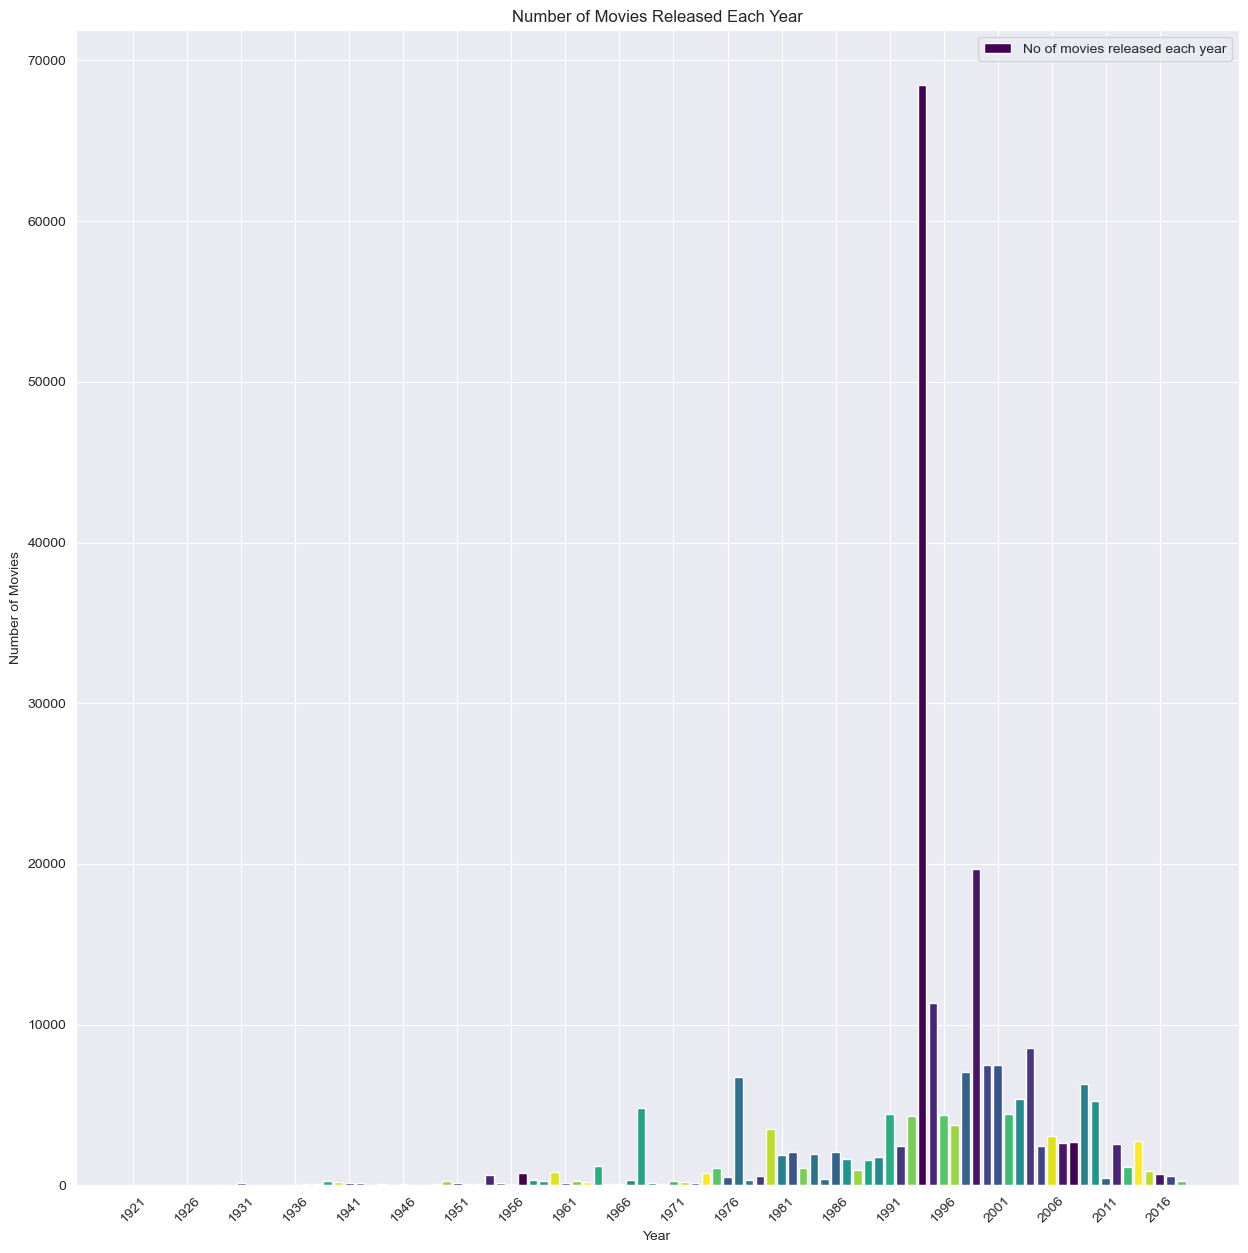

In [125]:
# Sorting the dataframe by years
sorted_df = new_df.sort_values('year_movie_released')

# Showing every 5 years
years_to_display = np.arange(sorted_df['year_movie_released'].min(), sorted_df['year_movie_released'].max() + 1, 5)

# Create a custom color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(years_to_display)))

# Creating the bar plot
plt.figure(figsize=(15, 15))
plt.bar(sorted_df['year_movie_released'].value_counts().index, sorted_df['year_movie_released'].value_counts().values, color=colors, label='No of movies released each year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies Released Each Year')
plt.xticks(years_to_display, rotation=45)
plt.legend(loc='best')
plt.show()

**It is interesting to note that even though most movies got released in the `90s` it is the period between `1991` and `1996` that most movies got released.**